In [82]:
import io
import math
import keras
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt

from keras.models import Sequential, model_from_json
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping

from google.colab import files

plt.style.use('default')

In [90]:
# https://finance.yahoo.com/quote/AAPL/history?period1=345427200&period2=1624233600&interval=1d&filter=history&frequency=1d&includeAdjustedClose=true (Max Historical Apple Daily)
resp = requests.get(f'https://query1.finance.yahoo.com/v7/finance/download/AAPL?period1=345427200&period2=1624233600&interval=1d&events=history&includeAdjustedClose=true') # download link
csv_data = io.StringIO(resp.content.decode('utf8').replace("'", '"'))
df = pd.read_csv(csv_data, sep=',')
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,1980-12-12,0.128348,0.128906,0.128348,0.128348,0.100751,469033600
1,1980-12-15,0.122210,0.122210,0.121652,0.121652,0.095495,175884800
2,1980-12-16,0.113281,0.113281,0.112723,0.112723,0.088485,105728000
3,1980-12-17,0.115513,0.116071,0.115513,0.115513,0.090676,86441600
4,1980-12-18,0.118862,0.119420,0.118862,0.118862,0.093304,73449600
...,...,...,...,...,...,...,...
10211,2021-06-14,127.820000,130.539993,127.070000,130.479996,130.479996,96906500
10212,2021-06-15,129.940002,130.600006,129.389999,129.639999,129.639999,62746300
10213,2021-06-16,130.369995,130.889999,128.460007,130.149994,130.149994,91815000
10214,2021-06-17,129.800003,132.550003,129.649994,131.789993,131.789993,96721700


In [91]:
df['EMA12'] = df['Adj Close'].ewm(span=12, adjust=False).mean()
df['EMA26'] = df['Adj Close'].ewm(span=26, adjust=False).mean()

df['MACD'] = df['EMA12'] - df['EMA26']
df['Signal'] = df['MACD'].ewm(span=9, adjust=False).mean() 

df['OBV'] = np.where(df['Adj Close'] == df['Adj Close'].shift(1), 0, np.where(df['Adj Close'] > df['Adj Close'].shift(1), df['Volume'], 
        np.where(df['Adj Close'] < df['Adj Close'].shift(1), -df['Volume'], df.iloc[0]['Volume']))).cumsum() # on-balance volume
df['OBV Percent'] = df['OBV'].pct_change() * 100
df['OBV Percent'] = round(df['OBV Percent'].fillna(0), 2) # on-balance volume as a percentage

df['Adj Close Delta'] = df['Adj Close'].diff().fillna(0) # delta between adj close

df['Next Adj Close'] = df['Adj Close'].shift(-1)
df.dropna(inplace=True)
df

,Date,Open,High,Low,Close,Adj Close,Volume,EMA12,EMA26,MACD,Signal,OBV,OBV Percent,Adj Close Delta,Next Adj Close
0,1980-12-12,0.128348,0.128906,0.128348,0.128348,0.100751,469033600,0.100751,0.100751,0.000000,0.000000,469033600,0.00,0.000000,0.095495
1,1980-12-15,0.122210,0.122210,0.121652,0.121652,0.095495,175884800,0.099942,0.100362,-0.000419,-0.000084,293148800,-37.50,-0.005256,0.088485
2,1980-12-16,0.113281,0.113281,0.112723,0.112723,0.088485,105728000,0.098180,0.099482,-0.001302,-0.000328,187420800,-36.07,-0.007010,0.090676
3,1980-12-17,0.115513,0.116071,0.115513,0.115513,0.090676,86441600,0.097025,0.098830,-0.001804,-0.000623,273862400,46.12,0.002191,0.093304
4,1980-12-18,0.118862,0.119420,0.118862,0.118862,0.093304,73449600,0.096453,0.098420,-0.001968,-0.000892,347312000,26.82,0.002628,0.098999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10210,2021-06-11,126.529999,127.440002,126.099998,127.349998,127.349998,53522400,126.201356,126.598074,-0.396718,-0.720339,161434764400,0.03,1.239997,130.479996
10211,2021-06-14,127.820000,130.539993,127.070000,130.479996,130.479996,96906500,126.859608,126.885624,-0.026015,-0.581474,161531670900,0.06,3.129998,129.639999
10212,2021-06-15,129.940002,130.600006,129.389999,129.639999,129.639999,62746300,127.287361,127.089651,0.197709,-0.425637,161468924600,-0.04,-0.839997,130.149994
10213,2021-06-16,130.369995,130.889999,128.460007,130.149994,130.149994,91815000,127.727766,127.316344,0.411422,-0.258225,161560739600,0.06,0.509995,131.789993


In [99]:
X = df[['Open','High','Low','Close','Volume','EMA12','EMA26','MACD','Signal','OBV Percent','Adj Close Delta']]
y = df[['Next Adj Close']]

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, stratify=None)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((7661, 11), (2554, 11), (7661, 1), (2554, 1))

In [93]:
X_scaler = MinMaxScaler(feature_range=(0, 1))
X_scaled = X_scaler.fit_transform(X_train)
X_train = pd.DataFrame(X_scaled, columns=[X_train.columns])

print ('X_train inputs:', X_train.columns)

window = 1 # 1 day

X_train_window=[]
y_train_window=[]
for i in range(window, len(X_train)):
  X_train_window.append(X_scaled[i-window:i, :])
  y_train_window.append(X_scaled[i, 0])

X_train_window, y_train_window = np.array(X_train_window), np.array(y_train_window)
X_train_window = np.reshape(X_train_window, (X_train_window.shape[0], X_train_window.shape[1], len(X_train.columns)))

print ('X_train_window.shape', X_train_window.shape)
print ('y_train_window.shape', y_train_window.shape)

X_train inputs: MultiIndex([(           'Open',),
            (           'High',),
            (            'Low',),
            (          'Close',),
            (         'Volume',),
            (          'EMA12',),
            (          'EMA26',),
            (           'MACD',),
            (         'Signal',),
            (    'OBV Percent',),
            ('Adj Close Delta',)],
           )
X_train_window.shape (7660, 1, 11)
y_train_window.shape (7660,)


Epoch 1/500
6/6 - 6s - loss: 0.0430 - mse: 0.0430 - mae: 0.0927 - mape: 1545.6744
Epoch 2/500
6/6 - 0s - loss: 0.0391 - mse: 0.0391 - mae: 0.0874 - mape: 3475.9561
Epoch 3/500
6/6 - 0s - loss: 0.0358 - mse: 0.0358 - mae: 0.0992 - mape: 8542.2773
Epoch 4/500
6/6 - 0s - loss: 0.0335 - mse: 0.0335 - mae: 0.1160 - mape: 11265.6348
Epoch 5/500
6/6 - 0s - loss: 0.0321 - mse: 0.0321 - mae: 0.1317 - mape: 18505.1367
Epoch 6/500
6/6 - 0s - loss: 0.0300 - mse: 0.0300 - mae: 0.1340 - mape: 19548.6738
Epoch 7/500
6/6 - 0s - loss: 0.0245 - mse: 0.0245 - mae: 0.1214 - mape: 16169.0107
Epoch 8/500
6/6 - 0s - loss: 0.0152 - mse: 0.0152 - mae: 0.0960 - mape: 13280.4033
Epoch 9/500
6/6 - 0s - loss: 0.0040 - mse: 0.0040 - mae: 0.0479 - mape: 8999.1484
Epoch 10/500
6/6 - 0s - loss: 0.0037 - mse: 0.0037 - mae: 0.0376 - mape: 1417.9365
Epoch 11/500
6/6 - 0s - loss: 0.0027 - mse: 0.0027 - mae: 0.0358 - mape: 3105.3748
Epoch 12/500
6/6 - 0s - loss: 0.0017 - mse: 0.0017 - mae: 0.0274 - mape: 2852.8394
Epoch 13

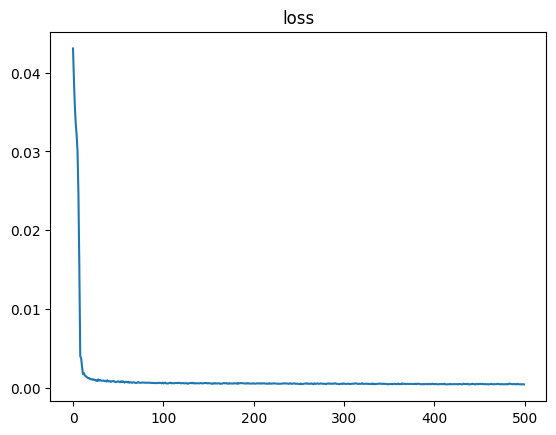

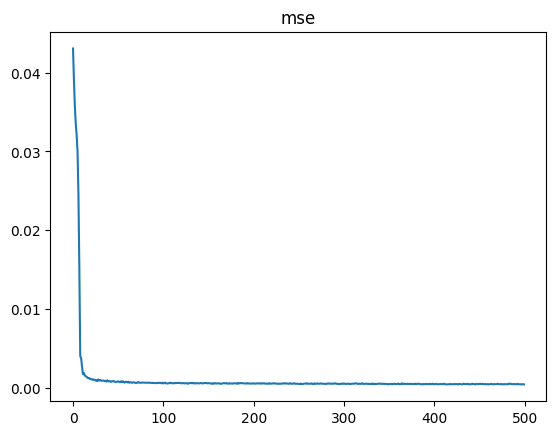

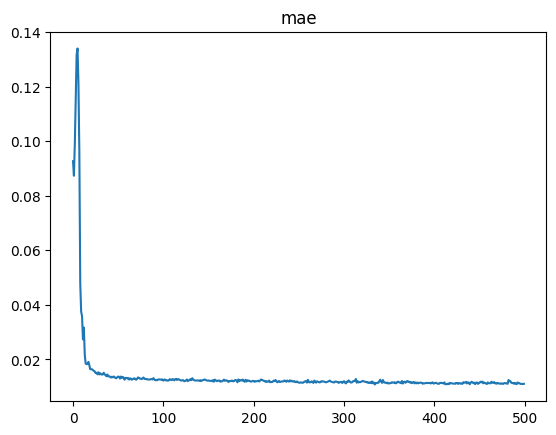

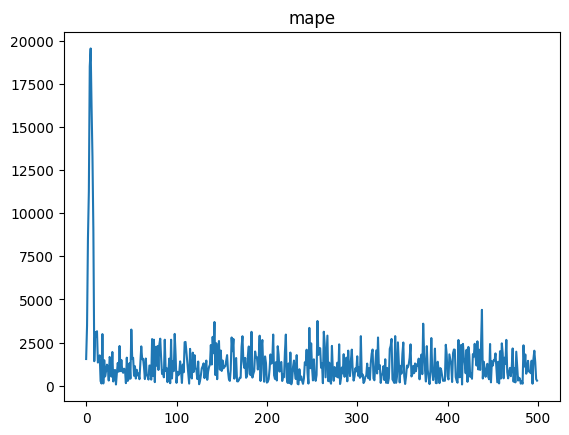

In [97]:
def create_model():
  model = Sequential()
  model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train_window.shape[1], len(X_train.columns)))) # layer 1 lstm
  model.add(Dropout(0.2)) # layer 1 dropout regularisation
  model.add(LSTM(units=50, return_sequences=True)) # layer 2 lstm
  model.add(Dropout(0.2)) # layer 2 dropout regularisation
  model.add(LSTM(units=50, return_sequences=True)) # layer 3 lstm
  model.add(Dropout(0.2)) # layer 3 dropout regularisation
  model.add(LSTM(units=50)) # layer 4 lstm
  model.add(Dropout(0.2)) # layer 4 dropout regularisation
  model.add(Dense(units=1)) # output layer
  model.compile(optimizer='adam', loss='mse', metrics=['mse','mae','mape']) # compile the rnn 
  return model

model = create_model()
history = model.fit(X_train_window, y_train_window, epochs=500, batch_size=1500, verbose=2)
model.summary()

for metric in history.history:
  plt.title(metric)
  plt.plot(history.history[metric])
  plt.show()

In [ ]:
'''Optionally save model, model.json and weights.h5'''

model_filename = f'model_apple_daily_{len(X_train.columns)}-inputs.json'
weights_filename = f'weights_apple_daily_{len(X_train.columns)}-inputs.h5'

!ls /content

# save structure to json
model_json = model.to_json()
with open(model_filename, 'w') as json_file:
  json_file.write(model_json)

# save weights to hdf5
model.save_weights(weights_filename)

files.download(f'/content/{model_filename}')
files.download(f'/content/{weights_filename}')

 model_apple_daily_12-inputs.json       weights_apple_daily_12-inputs.h5
'model_apple_daily_5-inputs (1).json'  'weights_apple_daily_5-inputs (1).h5'
 model_apple_daily_5-inputs.json        weights_apple_daily_5-inputs.h5
 sample_data


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
'''Optionally load model, model.json and weights.h5'''

model_filename = f'model_apple_daily_{len(X_train.columns)}-inputs.json'
weights_filename = f'weights_apple_daily_{len(X_train.columns)}-inputs.h5'

try:
  files.upload()
  !ls /content

  # read structure from json
  model = open(model_filename, 'r')
  json = model.read()
  model.close()
  model = model_from_json(json)

  # read weights from hdf5
  model.load_weights(f'/content/{weights_filename}')
except Exception as e:
  print (e)

Saving model_apple_daily_5-inputs.json to model_apple_daily_5-inputs (1).json
Saving weights_apple_daily_5-inputs.h5 to weights_apple_daily_5-inputs (1).h5
'model_apple_daily_5-inputs (1).json'  'weights_apple_daily_5-inputs (1).h5'
 model_apple_daily_5-inputs.json        weights_apple_daily_5-inputs.h5
 sample_data


In [100]:
X_scaler = MinMaxScaler(feature_range=(0, 1))
X_scaled = X_scaler.fit_transform(X_test)
X_test = pd.DataFrame(X_scaled, columns=[X_test.columns])

print ('X_test inputs:', X_test.columns)

y_scaler = MinMaxScaler(feature_range=(0, 1))
y_scaled = y_scaler.fit_transform(y)
y_test = pd.DataFrame(y_scaled, columns=[y.columns])

print ('y_test inputs:', y_test.columns[0])

X_test_window=[]
y_test_window=[]
for i in range(window, len(X_test)):
  X_test_window.append(X_scaled[i-window:i, :])
  y_test_window.append(X_scaled[i, 0])

X_test_window, y_test_window = np.array(X_test_window), np.array(y_test_window)
X_test_window = np.reshape(X_test_window, (X_test_window.shape[0], X_test_window.shape[1], len(X_test.columns)))

print ('X_test_window.shape:', X_test_window.shape)
print ('y_test_window.shape:', y_test_window.shape)

y_pred = model.predict(X_test_window)
y_pred = y_scaler.inverse_transform(y_pred)

print ('y_pred.shape:', y_pred.shape)

X_test inputs: MultiIndex([(           'Open',),
            (           'High',),
            (            'Low',),
            (          'Close',),
            (         'Volume',),
            (          'EMA12',),
            (          'EMA26',),
            (           'MACD',),
            (         'Signal',),
            (    'OBV Percent',),
            ('Adj Close Delta',)],
           )
y_test inputs: ('Next Adj Close',)
X_test_window.shape: (2553, 1, 11)
y_test_window.shape: (2553,)
y_pred.shape: (2553, 1)


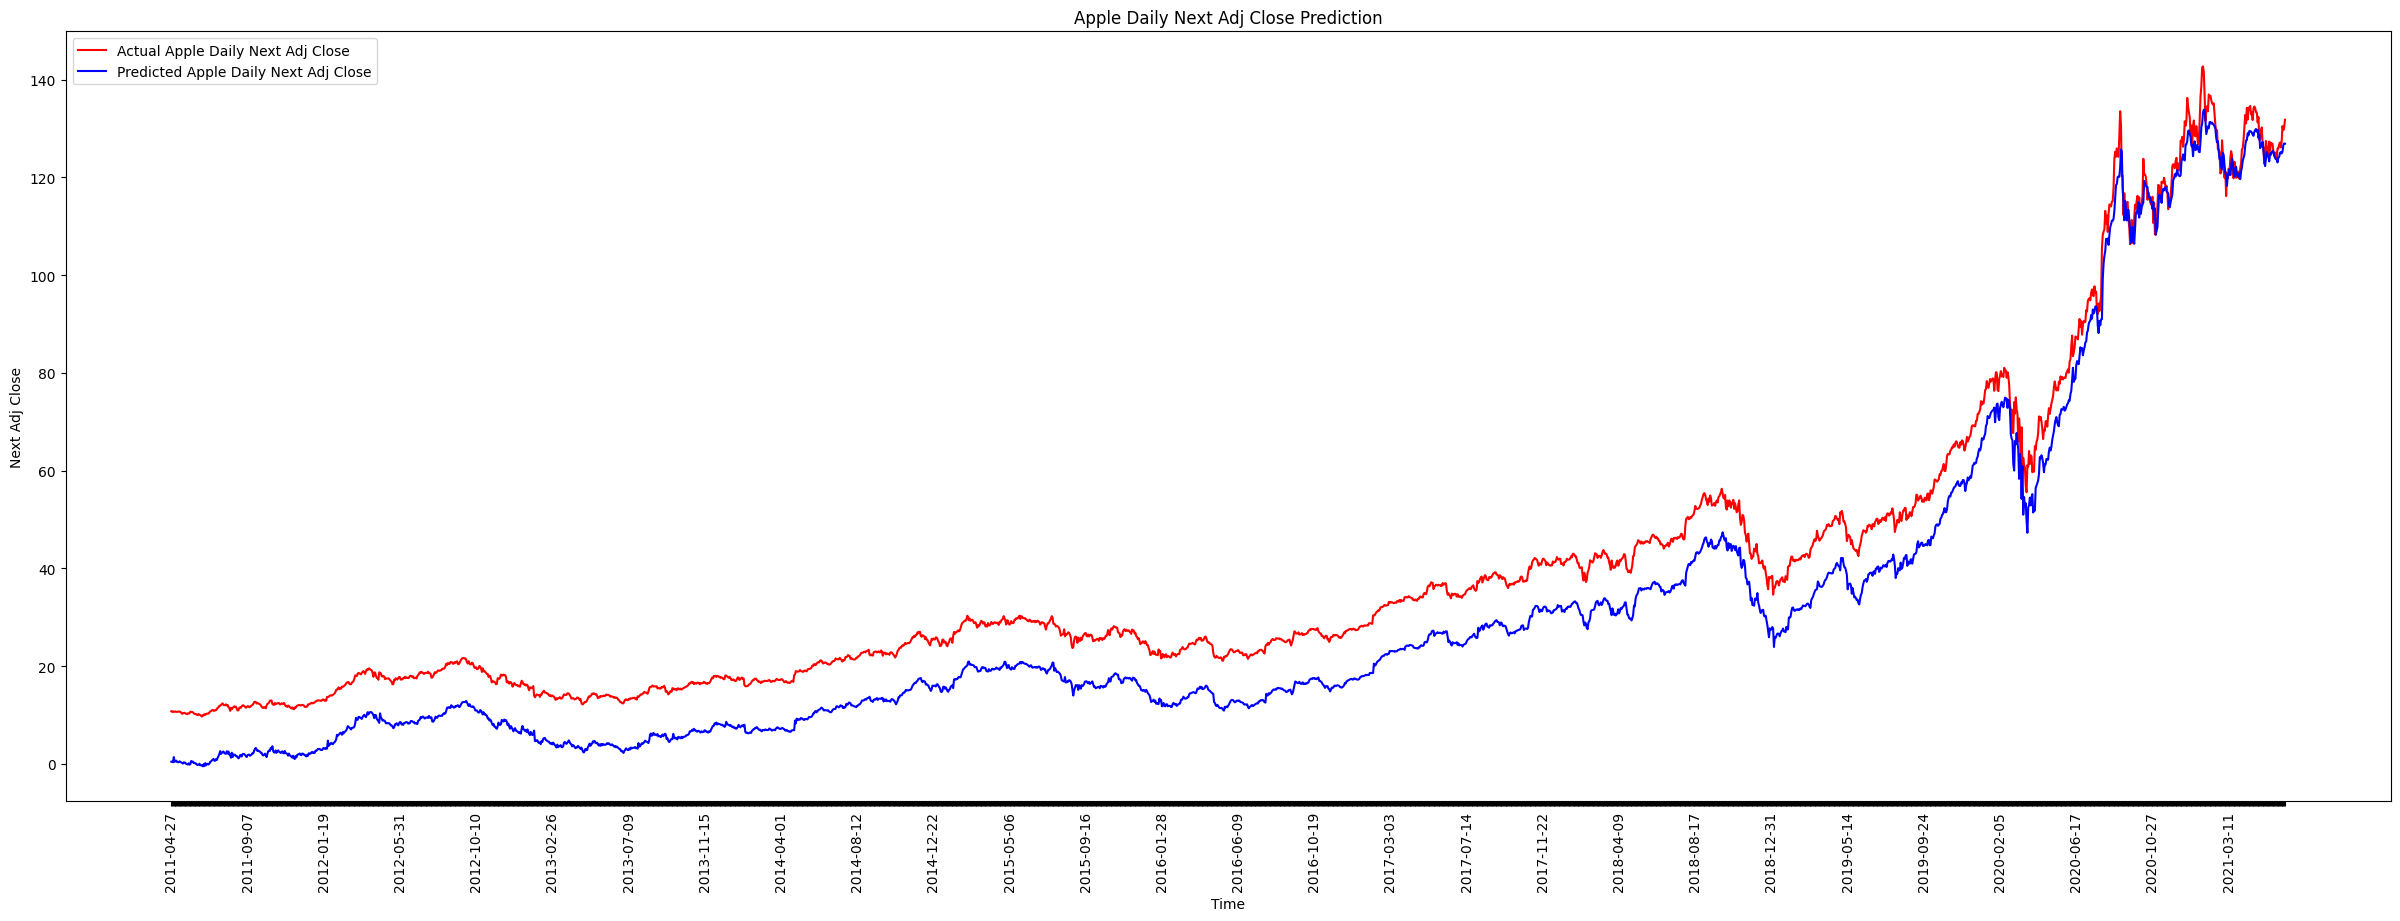

In [101]:
plt.figure(figsize=(30,10))
plt.plot(df['Date'].tail(len(y_pred)), df['Adj Close'][-len(y_pred):].values, color='red', label=f'Actual Apple Daily {y.columns.values[0].title()}')
plt.plot(df['Date'].tail(len(y_pred)), y_pred, color='blue', label=f'Predicted Apple Daily {y.columns.values[0].title()}')
plt.title(f'Apple Daily {y.columns.values[0].title()} Prediction')
plt.xlabel('Time')
plt.ylabel(f'{y.columns.values[0].title()}')
plt.xticks(rotation=90)

ax = plt.gca()
for index, label in enumerate(ax.xaxis.get_ticklabels()):
  if index % 92 != 0:
    label.set_visible(False)

plt.legend()
plt.show()

In [146]:
pd.set_option('mode.chained_assignment', None)

df_test = df.tail(len(y_pred))
df_test.loc[:, 'Predicted Next Adj Close'] = y_pred
df_test[['Open','High','Low','Close','Volume','EMA12','EMA26','MACD','Signal','OBV Percent','Adj Close Delta','Next Adj Close','Next Adj Close']]
df_test.rename(columns={'Next Adj Close': 'Actual Next Adj Close'}, errors='raise', inplace=True)
df_test

,Date,Open,High,Low,Close,Adj Close,Volume,EMA12,EMA26,MACD,Signal,OBV,OBV Percent,Adj Close Delta,Actual Next Adj Close,Predicted Next Adj Close
7662,2011-04-27,12.580000,12.583929,12.396429,12.505357,10.753392,356213200,10.553949,10.518959,0.034989,-0.033985,158941624800,-0.22,-0.008291,10.648976,0.441814
7663,2011-04-28,12.363929,12.491071,12.340000,12.383929,10.648976,360959200,10.568568,10.528590,0.039978,-0.019192,158580665600,-0.23,-0.104416,10.752778,0.452297
7664,2011-04-29,12.385000,12.641071,12.381071,12.504643,10.752778,1006345200,10.596908,10.545197,0.051712,-0.005011,159587010800,0.63,0.103802,10.634542,0.341463
7665,2011-05-02,12.490714,12.516786,12.339286,12.367143,10.634542,442713600,10.602698,10.551815,0.050883,0.006168,159144297200,-0.28,-0.118236,10.693504,1.386808
7666,2011-05-03,12.428214,12.496071,12.343571,12.435714,10.693504,313348000,10.616668,10.562310,0.054358,0.015806,159457645200,0.20,0.058962,10.735583,0.427920
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10210,2021-06-11,126.529999,127.440002,126.099998,127.349998,127.349998,53522400,126.201356,126.598074,-0.396718,-0.720339,161434764400,0.03,1.239997,130.479996,124.889809
10211,2021-06-14,127.820000,130.539993,127.070000,130.479996,130.479996,96906500,126.859608,126.885624,-0.026015,-0.581474,161531670900,0.06,3.129998,129.639999,125.243088
10212,2021-06-15,129.940002,130.600006,129.389999,129.639999,129.639999,62746300,127.287361,127.089651,0.197709,-0.425637,161468924600,-0.04,-0.839997,130.149994,126.576752
10213,2021-06-16,130.369995,130.889999,128.460007,130.149994,130.149994,91815000,127.727766,127.316344,0.411422,-0.258225,161560739600,0.06,0.509995,131.789993,126.930122
